# Homework 4

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from pygam import LogisticGAM
from matplotlib import cm 
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.calibration import calibration_curve

### Question 1

In [2]:
marketing_data = pd.read_csv("marketing.csv")
marketing_data_encoded = pd.get_dummies(columns=["job", "marital", "education","default", "housing","loan"],
                                        data=marketing_data)
marketing_data_encoded['y'] = np.where(marketing_data_encoded['y'] == 'yes',1,0)
X = marketing_data_encoded.drop(axis=1,columns=['y'])
y = marketing_data_encoded[['y']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [3]:
lmfit = LogisticRegression(C=100000).fit(X_train, y_train)



C:\Users\shuva\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#### Part (a)

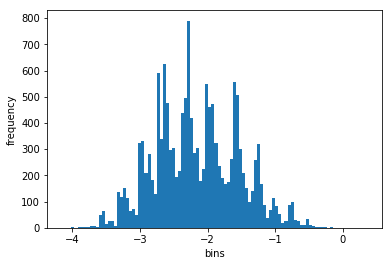

In [4]:
test_prob = lmfit.predict_proba(X_test)[:,1]
logit_scores = np.log(test_prob/(1-test_prob))
plt.hist(logit_scores,bins=100)
plt.xlabel("bins")
plt.ylabel("frequency")
plt.show()

#### Part (b)

In [5]:
combined_testdata = X_test.merge(y_test,how="inner",left_index=True,right_index=True)
class0_testdata = combined_testdata[combined_testdata.y ==0]
class0_testdata = class0_testdata.drop(axis=1,columns=['y'])
class1_testdata = combined_testdata[combined_testdata.y ==1]
class1_testdata = class1_testdata.drop(axis=1,columns=['y'])
test_prob0 = lmfit.predict_proba(class0_testdata)[:,1]
test_prob1 = lmfit.predict_proba(class1_testdata)[:,1]
logit_scores0 = np.log(test_prob0/(1-test_prob0))
logit_scores1 = np.log(test_prob1/(1-test_prob1))

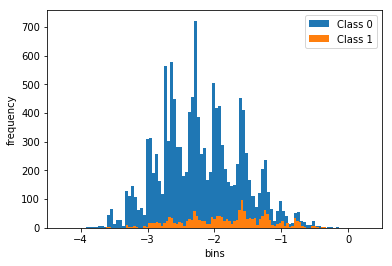

In [6]:
plt.hist(logit_scores0,bins=100,label="Class 0")
plt.hist(logit_scores1,bins=100,label="Class 1")
plt.xlabel("bins")
plt.xlim([-4.5,0.5])
plt.ylabel("frequency")
plt.gca().legend()
plt.show()

#### Part (c)

TPR and FPR will be the area under respective distribution curves in the cutoff region which is, $[T,\infty]$.

True Positive Rate (TPR) = $\int_T^\infty f_1(x)dx$, False Positive Rate (FPR) = $\int_T^\infty f_0(x)dx$

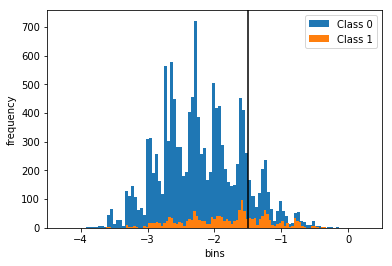

In [7]:
plt.hist(logit_scores0,bins=100,label="Class 0")
plt.hist(logit_scores1,bins=100,label="Class 1")
plt.xlabel("bins")
plt.xlim([-4.5,0.5])
plt.ylabel("frequency")
plt.axvline(x=-1.5,color='black')
plt.gca().legend()
plt.show()

In this case, area under the blue curve to the right of the black vertical line is FPR and correspondingly, area under the orange curve to the right of the black vertical line is TPR

#### Part (d)

Let $f(t) = FPR(t)$ and $g(t) = TPR(t)$. Then $AUC = \int_{t_0}^{t_f} g(t)f'(t)dt$, where $t_0 = \infty, t_f = -\infty$.

Now $f'(t) = -f_0(t)$, from part (c). and $g(t) = \int_{t}^\infty f_1(x)dx$. Plugging these, we get, 

$AUC = \int_{\infty}^{-\infty}\int_t^{\infty}f_1(x)dx (-f_0(t)dt) = \int_{-\infty}^{\infty}f_0(t)\int_t^{\infty}f_1(x)dxdt$.

#### Part (e)

$\mathbb{P}(S_1>S_0) = \int_{-\infty}^{\infty}\mathbb{P}(S_1>t)f_0(t)dt$, from law of total probability and $S_0$ is a random variable with density $f_0(x)$. Now $S_1$ is a random variable with density $f_1(x)$, thus $\mathbb{P}(S_1>t) = \int_t^\infty f_1(s)ds$.

$\mathbb{P}(S_1>S_0) = \int_{-\infty}^{\infty}\int_t^\infty f_1(s)dsf_0(t)dt = AUC$.

This shows that $AUC = \mathbb{P}(S_1>S_0)$, which means AUC is the probability that the score of the classifier accurately ranks a random point from class 1 higher than a random point from class 0.

### Question 2

#### Part (a)

In [8]:
#Input : Estimated class labels : [0,1] # need to be nX1 np array
#      : True class labels      : [0,1] # need to be nX1 np array
#      : False Positive Loss (L01), False Negative Loss (L10)
#Output : Tuple of
#Sensitivity (TPR), Specificity(FPR), Total Loss
def eval_estimate(estimate,truth,loss_FP,loss_FN):
    estimate = estimate.reshape(len(estimate),1)
    TP_FN_estimates = estimate[truth==1]
    sensitivity = np.mean(TP_FN_estimates==1)
    TN_FP_estimates = estimate[truth==0]
    specificity = np.mean(TN_FP_estimates==0)
    total_loss = loss_FN*np.sum(TP_FN_estimates==0) + loss_FP*np.sum(TN_FP_estimates==1)
    return (sensitivity,specificity,total_loss)
#estimate = ((logit_scores>-1)*1).reshape(len(estimate),1)
#truth = np.array(y_test)
#eval_estimate(estimate,truth,5,100)

In [9]:
unique_values = np.sort(np.unique(logit_scores))
midpoints = (unique_values[0:(len(unique_values)-1)]+unique_values[1:len(unique_values)])/2.0
sens, spec, loss = np.vectorize( lambda x: eval_estimate(logit_scores>x,
np.array(y_test, dtype=bool), 5, 100))(midpoints)

#### Part (b)

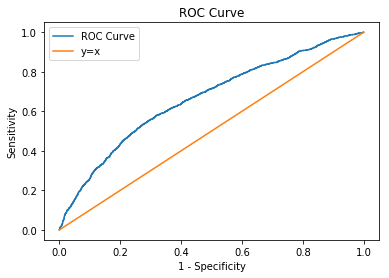

In [10]:
plt.plot(1-spec,sens,label="ROC Curve")
plt.plot(np.linspace(0,1,1000),np.linspace(0,1,1000),label="y=x")
plt.xlabel("1 - Specificity")
plt.ylabel("Sensitivity")
plt.gca().legend()
plt.title("ROC Curve")
plt.show()

#### Part (c)

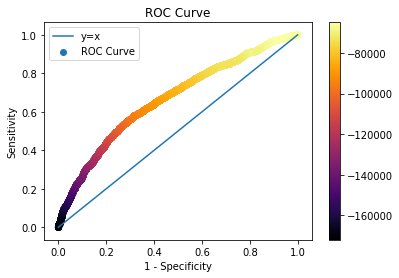

In [11]:
plt.scatter(1-spec,sens,label="ROC Curve",c=1-loss,cmap=cm.inferno)
plt.plot(np.linspace(0,1,1000),np.linspace(0,1,1000),label="y=x")
plt.xlabel("1 - Specificity")
plt.ylabel("Sensitivity")
plt.gca().legend()
plt.colorbar()
plt.title("ROC Curve")
plt.show()


#### Part (d)

In [12]:
N = np.sum(np.array(y_test, dtype=bool)==0)
P = np.sum(np.array(y_test, dtype=bool)==1)

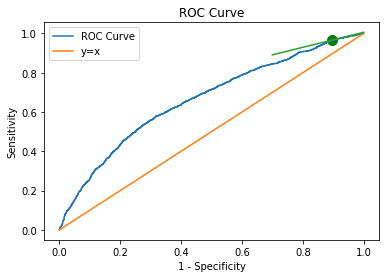

In [13]:
plt.plot(1-spec,sens,label="ROC Curve")
plt.plot(np.linspace(0,1,1000),np.linspace(0,1,1000),label="y=x")
plt.scatter(1-spec[np.argmin(loss)], sens[np.argmin(loss)], color='green', s=100)
plt.plot(np.linspace(.7,1,1000), 
         sens[np.argmin(loss)]+(np.linspace(.7,1,1000)-(1-spec[np.argmin(loss)]))*(N/P)*(5/100))
plt.xlabel("1 - Specificity")
plt.ylabel("Sensitivity")
plt.gca().legend()
plt.title("ROC Curve")
plt.show()

Region near the minimum loss point, ROC curve, straight line are not distinguishable very well. I plot the region near the point in the below plot and it shows that the straight line passing through the min loss point with the given slope is the tangent to the ROC curve that that particular point.

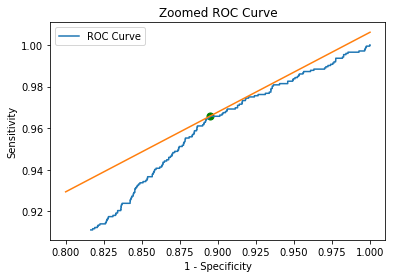

In [14]:
plt.plot(1-spec[:2500],sens[:2500],label="ROC Curve")
#plt.plot(np.linspace(0,1,1000),np.linspace(0,1,1000),label="y=x")
plt.scatter(1-spec[np.argmin(loss)], sens[np.argmin(loss)], color='green', s=50)
plt.plot(np.linspace(.8,1,1000), 
         sens[np.argmin(loss)]+(np.linspace(.8,1,1000)-(1-spec[np.argmin(loss)]))*(N/P)*(5/100))
plt.xlabel("1 - Specificity")
plt.ylabel("Sensitivity")
plt.gca().legend()
plt.title("Zoomed ROC Curve")
plt.show()

#### Part (e)

(i)

Total number of False Positives = $FPR\times N$

Total number of False Negatives = $FNR \times P$

Total Loss = $FPR\times N \times L_{FP} + FNR\times P \times L_{FN}$

(ii)
$FPR = \int_T^\infty f_0(x)dx$, $FNR = \int_{-\infty}^T f_1(x)dx$

(iii)

$Total Loss(T) = NL_{FP}\int_T^\infty f_0(x)dx + PL_{FN}\int_{-\infty}^T f_1(x)dx$

$\frac{\partial Total Loss(T)}{\partial T} = -NL_{FP}(-f_0(T)) + PL_{FN}f_1(T) = 0$

$\implies \frac{f_1(T)}{f_0(T)} = \frac{N}{P}\frac{L_{FP}}{L_{FN}} $

This shows that the slope of the tangent of the ROC curve parametrized by the TPR, FPR distributions is equal to $\frac{N}{P}\frac{L_{FP}}{L_{FN}}$.

### Question3

#### Part (a)

Optimal Probability Threshold to label a data point as class 1 is $P(Y=1|X=x) > \frac{L_{01}}{L_{01}+L{10}} = \frac{5}{105} $

In [15]:
opt_estimate = (logit_scores >np.log(5/105))*1
sens_opt,spec_opt,loss_opt = eval_estimate(opt_estimate,
np.array(y_test, dtype=bool), 5, 100)
print("Loss at optimal threshold is",loss_opt)
print("Minimum loss is",np.min(loss))

Loss at optimal threshold is 65310
Minimum loss is 64950


The loss with the optimal threshold is very close to the minimum loss point but not exactly the same.

#### Part (b)

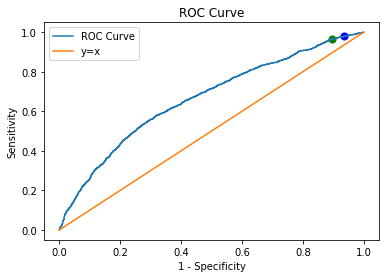

In [16]:
plt.plot(1-spec,sens,label="ROC Curve")
plt.plot(np.linspace(0,1,1000),np.linspace(0,1,1000),label="y=x")
plt.scatter(1-spec_opt, sens_opt, color='blue', s=50)
plt.scatter(1-spec[np.argmin(loss)], sens[np.argmin(loss)], color='green', s=50)
plt.xlabel("1 - Specificity")
plt.ylabel("Sensitivity")
plt.gca().legend()
plt.title("ROC Curve")
plt.show()

The blue point shows the one with optimal threshold and the green with minimum loss. As seen in part (a), the loss values are not exactly the same and thus doesn't match exactly. 

The optimal threshold corresponds to minimizing the expected prediction error, which is, 

$EPE = \mathbb{E}(\mathcal{L}(T,f(X)))$.

From homework 3, the $\hat{EPE}$ can be simplified as,

$\hat{EPE} = \sum_{x\in\Omega}L_{01}P(Y=0|X=x) \mathbb{1}_{P(Y=0|X=x) \leq \frac{L_{01}}{L_{01}+L_{10}}}+
L_{10}P(Y=1|X=x) \mathbb{1}_{P(Y=1|X=x) \leq \frac{L_{01}}{L_{01}+L_{10}}}$

Indicator corresponds to when the classifier makes an incorrect classification and $\Omega$ corresponds to the set of all datapoints. In our case, let $|\Omega| = N$, $\Omega_{FP}$ and $\Omega_{FN}$ be the class of datapoints which are false positives and false negatives respectively. Then above can be simplified as,


$\hat{EPE} = L_{01}\sum_{x\in\Omega_{FP}}P(Y=0|X=x) \mathbb{1}_{P(Y=0|X=x) \leq \frac{L_{01}}{L_{01}+L_{10}}}+
L_{10}P(Y=1|X=x) \sum_{x\in\Omega_{FN}}\mathbb{1}_{P(Y=1|X=x) \leq \frac{L_{01}}{L_{01}+L_{10}}}$

In our total loss calculation, we are estimating $\sum_{x\in\Omega_{FP}}P(Y=0|X=x) \mathbb{1}_{P(Y=0|X=x) \leq \frac{L_{01}}{L_{01}+L_{10}}}$ and $\sum_{x\in\Omega_{FN}}\mathbb{1}_{P(Y=1|X=x) \leq \frac{L_{01}}{L_{01}+L_{10}}}$ with total number of False Positive and False Negative estimates in our dataset which results into the difference and this threshold rule resulted loss not matching with the minimum loss. 

As we gather more test data, this optimal threshold generated loss will converge towards the minimum possible loss in the dataset.

#### Part (c)

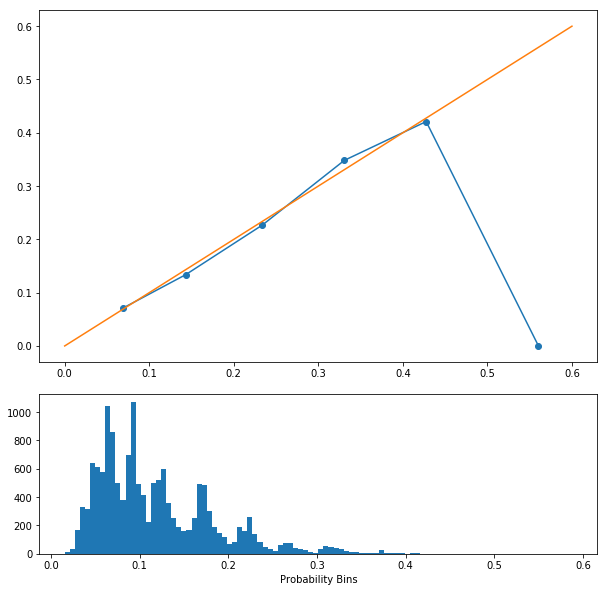

In [17]:
plt.figure(figsize=(10, 10))
fraction_positives, mean_predicted_value = calibration_curve(y_test, test_prob, n_bins=10)
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))
ax1.plot(mean_predicted_value, fraction_positives, 'o-')
ax1.plot(np.linspace(0,0.6,1000),np.linspace(0,0.6,1000))
ax2.hist(test_prob,bins=100)
plt.xlabel("Probability Bins")
plt.show()

In [18]:
print("Number of points with pred prob more than 0.4 is", np.sum(test_prob>0.4))

Number of points with pred prob more than 0.4 is 22


From above plots, the classifier seems well calibrated in the (0.00,0.4) region. It has very poor calibration in the (0.4,0.6) region. By looking at the histogram of the probability bin frequencies, we can see that there are very few data points which has prediction probabilities beyond 0.4 and expected number of positives in that region of $\geq 0.4$ will be 0.88 which is even less than 1.

Thus there are very few data points beyond the region where the model is poorly calibrated, and in the model is well calibrated before that region. The poor calibration results can be due to any missing feature in the dataset because of which the classifier is unable to predict very well, or some non-linearity is present between the features and the response variable which the linear logistic classifier is not able to capture.

#### Part (d)

In [19]:
GAMfit = LogisticGAM().gridsearch(np.array(X_train), np.array(y_train), lam = np.logspace(-2, 3, 30))

100% (30 of 30) |########################| Elapsed Time: 0:05:07 Time:  0:05:07


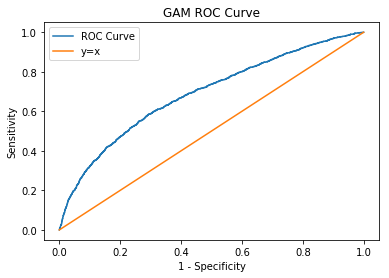

In [20]:
GAMtest_prob = GAMfit.predict_proba(X_test)
GAMlogit_scores = np.log(GAMtest_prob/(1-GAMtest_prob))
GAMunique_values = np.sort(np.unique(GAMlogit_scores))
GAMmidpoints = (GAMunique_values[0:(len(GAMunique_values)-1)]+GAMunique_values[1:len(GAMunique_values)])/2.0
GAMsens, GAMspec, GAMloss = np.vectorize( lambda x: eval_estimate(GAMlogit_scores>x,
np.array(y_test, dtype=bool), 5, 100))(GAMmidpoints)
plt.plot(1-GAMspec,GAMsens,label="ROC Curve")
plt.plot(np.linspace(0,1,1000),np.linspace(0,1,1000),label="y=x")
plt.xlabel("1 - Specificity")
plt.ylabel("Sensitivity")
plt.gca().legend()
plt.title("GAM ROC Curve")
plt.show()

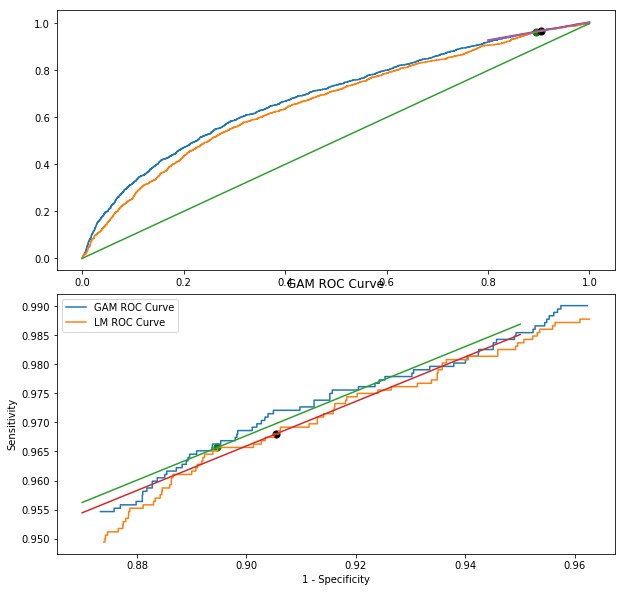

In [21]:
plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((4, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((4, 1), (2, 0), rowspan=2)
ax1.plot(1-GAMspec,GAMsens,label="GAM ROC Curve")
ax1.plot(1-spec,sens,label="LM ROC Curve")
ax1.plot(np.linspace(0,1,1000),np.linspace(0,1,1000),label="y=x")
ax1.scatter(1-spec[np.argmin(loss)], sens[np.argmin(loss)], color='green', s=50)
ax1.scatter(1-spec[np.argmin(GAMloss)], sens[np.argmin(GAMloss)], color='black', s=50)
ax1.plot(np.linspace(.8,1,1000), 
         sens[np.argmin(loss)]+(np.linspace(.8,1,1000)-(1-spec[np.argmin(loss)]))*(N/P)*(5/100))
ax1.plot(np.linspace(.8,1,1000), 
         sens[np.argmin(GAMloss)]+(np.linspace(.8,1,1000)-(1-spec[np.argmin(GAMloss)]))*(N/P)*(5/100))
ax2.plot(1-GAMspec[500:1700],GAMsens[500:1700],label="GAM ROC Curve")
ax2.plot(1-spec[500:1700],sens[500:1700],label="LM ROC Curve")
ax2.scatter(1-spec[np.argmin(loss)], sens[np.argmin(loss)], color='green', s=50)
ax2.scatter(1-spec[np.argmin(GAMloss)], sens[np.argmin(GAMloss)], color='black', s=50)
ax2.plot(np.linspace(.87,.95,1000), 
         sens[np.argmin(loss)]+(np.linspace(.87,.95,1000)-(1-spec[np.argmin(loss)]))*(N/P)*(5/100))
ax2.plot(np.linspace(.87,.95,1000), 
         sens[np.argmin(GAMloss)]+(np.linspace(.87,.95,1000)-(1-spec[np.argmin(GAMloss)]))*(N/P)*(5/100))
plt.xlabel("1 - Specificity")
plt.ylabel("Sensitivity")
plt.gca().legend()
plt.title("GAM ROC Curve")
plt.show()

In [22]:
GAMopt_estimate = (GAMlogit_scores >np.log(5/105))*1
GAMsens_opt,GAMspec_opt,GAMloss_opt = eval_estimate(GAMopt_estimate,
np.array(y_test, dtype=bool), 5, 100)
print("Minimum GAM Loss",np.min(GAMloss))
print("GAM Loss with optimal threshold",GAMloss_opt)
print("Minimum LM Loss",np.min(loss))
print("LM Loss with optimal threshold",loss_opt)

Minimum GAM Loss 64525
GAM Loss with optimal threshold 64845
Minimum LM Loss 64950
LM Loss with optimal threshold 65310


I plot the ROC curves of the two classifier together and show the zoomed plot of the min-loss points on the curve along with the tangent lines. 

I can observe that the tangent line and the ROC curve for the GAM classifier lies slightly above the LM logisitic classifier, which shows better AUC and thus better classification accuracy by the GAM classifier. Also from above prints, we can see that the minimum loss attained by GAM classifier is better than LM and loss at optimal threshold is also improved for GAM classifier.

### Question 4

In [23]:
banknote_data = pd.read_csv("banknote_measurements.csv")
banknote_data['y'] = np.where(banknote_data.counterfeit == 'counterfeit',1,0)

In [24]:
X = banknote_data[['Length','Left','Right', 'Bottom', 'Top']]
y = banknote_data[['y']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,
random_state=1)

#### Part (a)

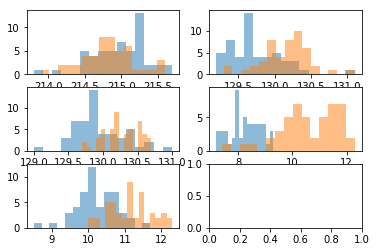

In [25]:
fig, ax = plt.subplots(3, 2)
#Left Top
ax[0, 0].hist(X_train['Length'][(y_train==0).y],alpha=0.5,bins=15)
ax[0, 0].hist(X_train['Length'][(y_train==1).y],alpha=0.5,bins=15)
#Left Middle
ax[1, 0].hist(X_train['Left'][(y_train==0).y],alpha=0.5,bins=15)
ax[1, 0].hist(X_train['Left'][(y_train==1).y],alpha=0.5,bins=15)
#Left Bottom
ax[2, 0].hist(X_train['Top'][(y_train==0).y],alpha=0.5,bins=15)
ax[2, 0].hist(X_train['Top'][(y_train==1).y],alpha=0.5,bins=15)
#Right Top
ax[0, 1].hist(X_train['Right'][(y_train==0).y],alpha=0.5,bins=15)
ax[0, 1].hist(X_train['Right'][(y_train==1).y],alpha=0.5,bins=15)
#Right Middle
ax[1, 1].hist(X_train['Bottom'][(y_train==0).y],alpha=0.5,bins=15)
ax[1, 1].hist(X_train['Bottom'][(y_train==1).y],alpha=0.5,bins=15)
plt.show()

Above shows the 5 histogram plots. Most of the histograms have significant overlap, except the features corresponding to column 'Top', 'Bottom' as I can see some distinction between the distribution for the two classes. None of the features perfectly separate the classes though as all of the histograms have some amount of overalp between them across the classes.

#### Part (b)

In [26]:
lda = LinearDiscriminantAnalysis(n_components=2)
ldafit = lda.fit(X_train,y_train)

C:\Users\shuva\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [27]:
y_pred = ldafit.predict(X_test)
print("Confusion Matrix is:")
print(confusion_matrix(y_test, y_pred))
print("Misclassification Rate :", np.mean(y_pred!=y_test.y))

Confusion Matrix is:
[[47  1]
 [ 6 46]]
Misclassification Rate : 0.07


#### Part (c)

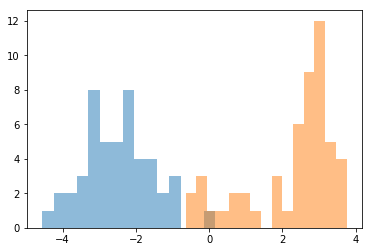

In [28]:
X_test_transformed = ldafit.transform(X_test)
plt.hist(X_test_transformed[(y_test==0).y],alpha=0.5,bins=15)
plt.hist(X_test_transformed[(y_test==1).y],alpha=0.5,bins=15)
plt.show()

The LDA transformed feature space seems very well separable between two classes compared to the prior collection of histograms in part (a). There is a very small overlap which accounts for the misclassification by the LDA classifier.